In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline

In [2]:
from helpers.convert_to_var_foo import convert_to_var

In [3]:
class Enet(nn.Module):
    def __init__(self, num_actions, input_dim,
                 num_hidden=2, hidden_size=512):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(nn.ReLU())
        for i in range(num_hidden):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, num_actions))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
        self.set_weights()


    def set_weights(self):
        state_dict = self.net.state_dict()
        keys = sorted(state_dict.keys())
        state_dict[keys[-2]] = torch.zeros_like(state_dict[keys[-2]])
        self.net.load_state_dict(state_dict)


    def forward(self, x):
        out = self.net(x)
        return out

In [7]:
alpha = 0.2
gamma_E = 0.9

def go_tree_cycle(k, e_lr=1e-5):
    e_model = Enet(num_actions=k+1, input_dim=50, hidden_size=512, num_hidden=1)

    optimizer = torch.optim.Adam(e_model.parameters(), lr=e_lr)
    MSEloss = nn.MSELoss()
    
    pseudo_counts = []
    for step in range(50):
        for i in range(1,k+1):
            start_state = convert_to_var(np.concatenate([np.ones(25), np.zeros(25)]))
            s0_state = convert_to_var(np.ones(50))
            
            loss = MSEloss(e_model.forward(start_state)[0],
                           gamma_E * e_model.forward(s0_state)[i].detach() )
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss = MSEloss(e_model.forward(s0_state)[i],
                           convert_to_var(np.zeros(1)))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        e_values = e_model.forward(start_state).data.numpy()[0]
        #print(e_value)
        cnt  = np.log(e_values) / np.log(1 - e_lr) + np.log(2) / np.log(1-e_lr)
        pseudo_counts.append(cnt)
    return pseudo_counts

In [8]:
%%time
k_range = [10, 20]

results_3 = []
for k in k_range:
    print(k)
    pseudo_counts = go_tree_cycle(k, e_lr=1e-3)
    results_3.append(pseudo_counts)


results_4 = []
for k in k_range:
    print(k)
    pseudo_counts = go_tree_cycle(k, e_lr=1e-4)
    results_4.append(pseudo_counts)
    
results_5 = []
for k in k_range:
    print(k)
    pseudo_counts = go_tree_cycle(k, e_lr=1e-5)
    results_5.append(pseudo_counts)

10
20
10
20
10
20
CPU times: user 15min 56s, sys: 1.22 s, total: 15min 57s
Wall time: 17min 2s


Text(0.5,1,'lr=1e-05')

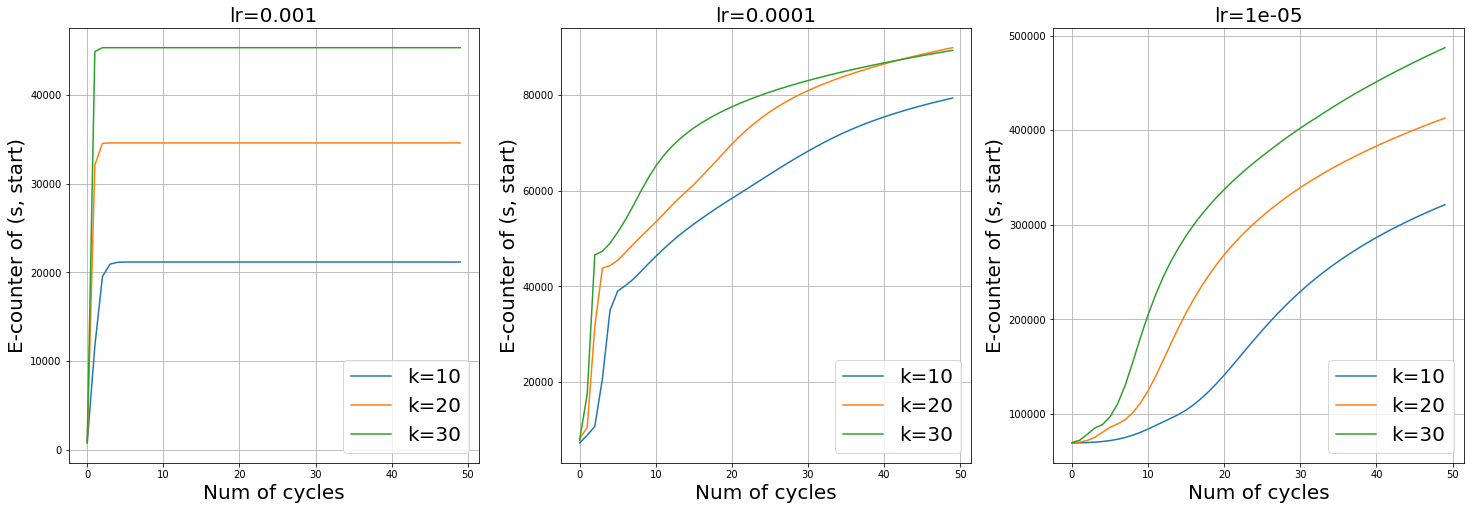

In [58]:
plt.figure(figsize=(25, 8))

fontsize=20

plt.subplot(1, 3, 1)
for i in range(len(k_range)):
    plt.plot(results_3[i], label="k={}".format(k_range[i]))
plt.grid()
plt.xlabel('Num of cycles', fontsize=fontsize)
plt.ylabel('E-counter of (s, start)', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)
plt.title('lr={}'.format(1e-3), fontsize=fontsize)


plt.subplot(1, 3, 2)
for i in range(len(k_range)):
    plt.plot(results_4[i], label="k={}".format(k_range[i]))
plt.grid()
plt.xlabel('Num of cycles', fontsize=fontsize)
plt.ylabel('E-counter of (s, start)', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)
plt.title('lr={}'.format(1e-4), fontsize=fontsize)


plt.subplot(1, 3, 3)
for i in range(len(k_range)):
    plt.plot(results_5[i], label="k={}".format(k_range[i]))
plt.grid()
plt.xlabel('Num of cycles', fontsize=fontsize)
plt.ylabel('E-counter of (s, start)', fontsize=fontsize)
plt.legend(loc='lower right', fontsize=fontsize)
plt.title('lr={}'.format(1e-5), fontsize=fontsize)



In [120]:
def plot_results(results, titles, dim_range):
    linewidth=4
    fontsize=15
    
    num_plots = len(results)
    plt.figure(figsize=(7*num_plots,5))
    
    for i in range(num_plots):    
        ax = plt.subplot(1, num_plots, i+1)
        for key in sorted(results[i].keys()): 
            arr = results[i][key]

            min_ = arr.min(axis=0)
            max_ = arr.max(axis=0)
            mean = arr.mean(axis=0)

            plt.plot(dim_range, mean, label=key, linewidth=linewidth)
            ax.fill_between(dim_range, min_, max_, alpha=0.15)

        plt.legend(loc='upper left', fontsize=fontsize)
        plt.grid()
        plt.ylabel('num epochs', fontsize=fontsize)
        plt.xlabel('dim', fontsize=fontsize)
        plt.title(titles[i], fontsize=fontsize)

In [150]:
deep_chain = np.load('results/dqn_environments/deep_chain.npy')

In [151]:
deep_chain_ucb = np.load('results/dqn_environments/deep_chain_e_ucb.npy')

In [146]:
deep_chain_lll = np.load('results/dqn_environments/deep_chain/lll_eps_greedy.npy')

In [153]:
deep_chain

array([[493., 506., 999., 855., 966., 999.],
       [491., 498., 512., 552., 999., 999.],
       [493., 515., 999., 991., 999., 999.],
       [497., 999., 499., 999., 983., 999.],
       [500., 506., 999., 999., 999., 826.]])

In [152]:
deep_chain_ucb

array([[493., 506., 570., 518., 716., 999.],
       [491., 498., 512., 520., 999., 586.],
       [493., 515., 691., 524., 751., 506.],
       [497., 619., 499., 791., 535., 641.],
       [500., 506., 508., 630., 996., 531.]])

In [154]:
results = {'eps-greedy DQN': deep_chain,
           'eps-greedy DQN + e-UCB': deep_chain_ucb,
           }

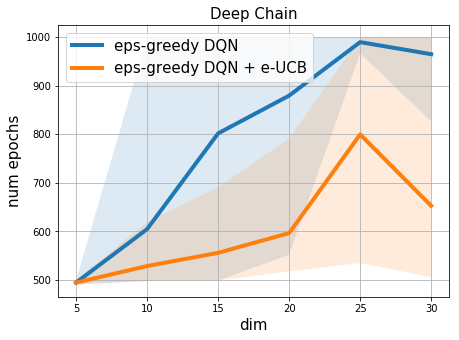

In [155]:
plot_results([results], titles=['Deep Chain'], dim_range=[5,10,15,20,25,30])

In [107]:
import os

In [114]:
directory = 'results/dqn_environments/deep_chain/'

In [111]:
for file in os.listdir(directory):
    if 'lll' in file:
        print(file)

lll_eps_greedy_ucb.npy
lll_eps_greedy_ucb_zeros.npy
lll_eps_greedy_ones.npy
lll_eps_greedy_ucb_ones.npy
lll_eps_greedy.npy
lll_eps_greedy_zeros.npy


In [123]:
lll_groups = [['lll_eps_greedy', 'lll_eps_greedy_ucb'],
          ['lll_eps_greedy_zeros', 'lll_eps_greedy_ucb_zeros'],
          ['lll_eps_greedy_ones', 'lll_eps_greedy_ucb_ones']]

In [124]:
all_lll_results = []
for group in lll_groups:
    results = {}
    for name in group:
        results[name] = np.load(directory+name+'.npy')
    all_lll_results.append(results)

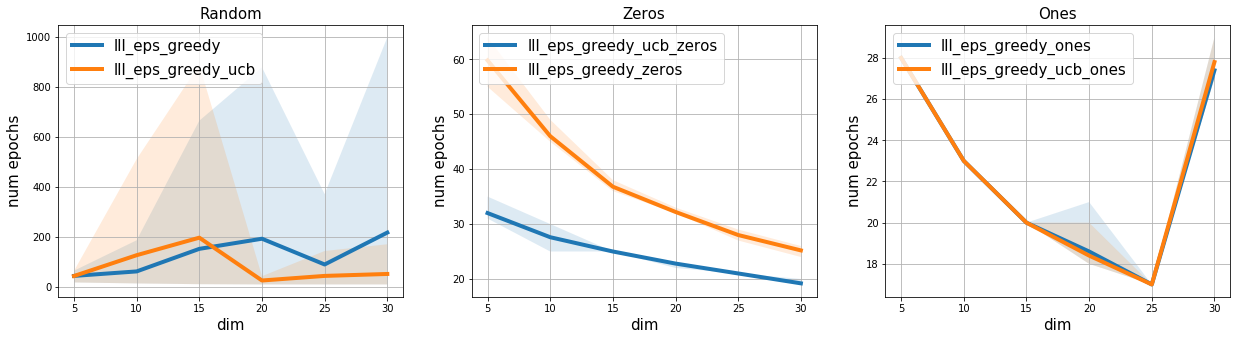

In [127]:
plot_results(all_lll_results, ['Random', 'Zeros', 'Ones'], dim_range=[5,10,15,20,25,30])

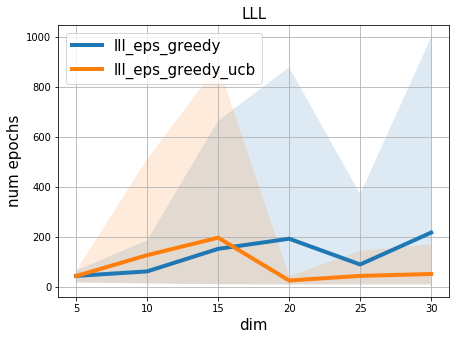

In [134]:
plot_results(all_lll_results[:1], ['LLL'], dim_range=[5,10,15,20,25,30])

In [129]:
groups = [['eps_greedy', 'eps_greedy_ucb'],
          ['eps_greedy_zeros', 'eps_greedy_ucb_zeros'],
          ['eps_greedy_ones', 'eps_greedy_ucb_ones']]

In [130]:
all_results = []
for group in lll_groups:
    results = {}
    for name in group:
        results[name] = np.load(directory+name+'.npy')
    all_results.append(results)


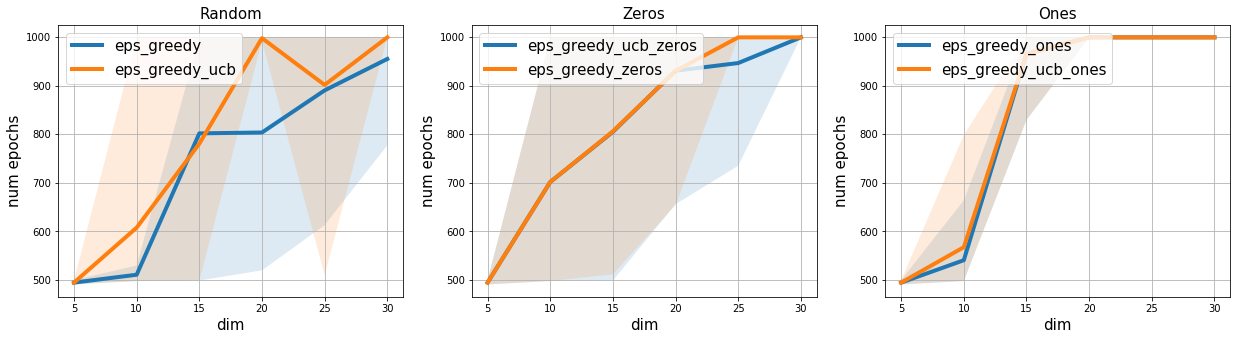

In [131]:
plot_results(all_results, ['Random', 'Zeros', 'Ones'], dim_range=[5,10,15,20,25,30])